# Modelo de Random Forest

La idea de este notebook es presentar un caso de uso del algoritmo de random forest.

El dataset fue tomado del National Centers For Eviromental Information https://www.ncdc.noaa.gov/cdo-web/ , y se tomo la idea general para esta notebook de Will Koehrsen [Github](https://github.com/WillKoehrsen/Data-Analysis/tree/master/random_forest_explained).

El problema que abordaremos es la predicción de la temperatura máxima 'para mañana' en la ciudad de Seattle utilizando un año de datos meteorológicos.
En el dataset contiene un año de temperaturas máximas históricas y las temperaturas de los dos días anteriores. 

Recordemos que este es un problema de aprendizaje supervisado ya que utilizaremos tanto las características (datos de la ciudad) como la variable target (temperatura) que queremos predecir. Durante el entrenamiento, le pasaremos al modelo de Random Forest tanto las características como los targets y éste debe aprender a asignar los datos a una predicción. Además, se trata de una tarea de regresión porque el valor del objetivo es continuo (a diferencia de las clases discretas de la clasificación). Esto es todo lo que necesitamos, así que empecemos.

Los siguientes pasos constituyen la base de cualquier flujo de trabajo de aprendizaje automático una vez que tenemos un problema y un modelo:

* Plantear la pregunta y determinar los datos necesarios
* Adquirir los datos en un formato accesible
* Identificar y corregir los puntos de datos/anomalías que faltan, según sea necesario
* Preparar los datos para que el modelo pueda ingestarlos
* Establecer un modelo de referencia que se pretende superar
* Entrenar el modelo con los datos de entrenamiento
* Hacer predicciones con los datos de prueba
* Compare las predicciones con los targets del conjunto de test conocido y calcular las métricas de rendimiento
* Si el rendimiento no es satisfactorio, ajuste el modelo, adquiera más datos o pruebe una técnica de modelado diferente
* Interprete el modelo y comunique los resultados de forma visual y numérica

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('temps.csv')
df.drop(columns=['forecast_noaa','forecast_acc'	,'forecast_under','friend'], axis=1, inplace=True)
df.head(5)

,year,month,day,week,temp_2,temp_1,average,actual
0,2016,1,1,Fri,45,45,45.6,45
1,2016,1,2,Sat,44,45,45.7,44
2,2016,1,3,Sun,45,44,45.8,41
3,2016,1,4,Mon,44,41,45.9,40
4,2016,1,5,Tues,41,40,46.0,44


In [3]:
df.columns

Index(['year', 'month', 'day', 'week', 'temp_2', 'temp_1', 'average',
       'actual'],
      dtype='object')

In [4]:
df.dtypes

year         int64
month        int64
day          int64
week        object
temp_2       int64
temp_1       int64
average    float64
actual       int64
dtype: object

Las columnas que utilizaremos son las siguientes: 

* year:  2016 para todos los puntos de datos

* month: número para el mes del año

* day: número para el día del año

* week: día de la semana como cadena de caracteres

* temp_2: temperatura máxima 2 días antes

* temp_1: temperatura máxima de 1 día antes

* average: temperatura máxima media histórica

* actual: medición de la temperatura máxima

Hagamos un describe para ver si tenemos algun valor anómalo en la data

Cambiemos de unidades la temperatura de fahrenheit a celsius para esto creemos una función.

In [5]:
def f(x):
    x = (x  - 32)/1.8
    return round(float(x),2)

In [6]:
df['temp_2'] = df['temp_2'].apply(f)
df['temp_1'] = df['temp_1'].apply(f)
df['average'] = df['average'].apply(f)
df['actual'] = df['actual'].apply(f)

In [7]:
df.describe()

,year,month,day,temp_2,temp_1,average,actual
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,17.029080,17.056207,15.422500,16.968420
std,0.0,3.498380,8.772982,6.758302,6.733401,5.848529,6.552096
min,2016.0,1.000000,1.000000,1.670000,1.670000,7.280000,1.670000
25%,2016.0,3.000000,8.000000,12.220000,12.220000,9.985000,12.220000
50%,2016.0,6.000000,15.000000,16.945000,16.945000,14.555000,16.945000
75%,2016.0,10.000000,23.000000,21.670000,21.670000,20.572500,21.670000
max,2016.0,12.000000,31.000000,47.220000,47.220000,25.220000,33.330000


No hay puntos de datos que aparezcan inmediatamente como anómalos y no hay ceros en ninguna de las columnas de medición. Otro método para verificar la calidad de los datos es hacer gráficos básicos. A menudo es más fácil detectar anomalías utilizando gráficos.

<AxesSubplot:>

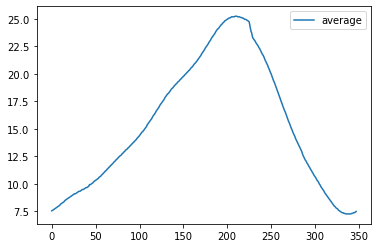

In [8]:
df.plot(kind='line', y='average')

<AxesSubplot:>

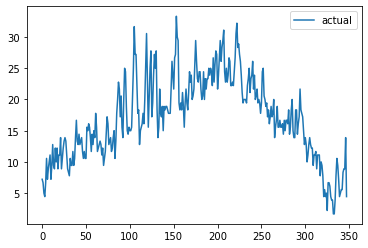

In [9]:
df.plot(kind='line', y='actual')

<AxesSubplot:>

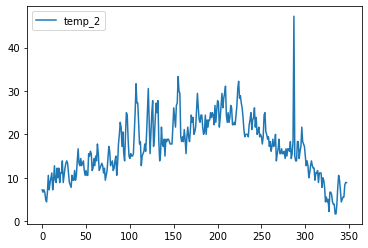

In [10]:
df.plot(kind='line', y='temp_2')

<AxesSubplot:>

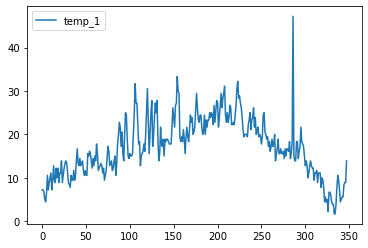

In [11]:
df.plot(kind='line', y='temp_1')

Al examinar las estadísticas cuantitativas y los gráficos, podemos confiar en la alta calidad de nuestros datos. No hay valores atípicos claros y, aunque faltan algunos puntos, no desvirtúan el análisis.

La idea ahora es utilizar one-hot encoding. Este proceso toma variables categóricas, como los días de la semana, y las convierte en una representación numérica. Podríamos simplemente asignar los días de la semana a los números del 1 al 7, pero esto podría llevar al algoritmo a dar más importancia al domingo porque tiene un valor numérico más alto. En su lugar, cambiamos la única columna de días de la semana por siete columnas de datos binarios.

In [12]:
# One-hot encode the data using pandas get_dummies
df = pd.get_dummies(df)# Display the first 5 rows of the last 12 columns
df.iloc[:,5:].head(5)

,average,actual,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,7.56,7.22,1,0,0,0,0,0,0
1,7.61,6.67,0,0,1,0,0,0,0
2,7.67,5.00,0,0,0,1,0,0,0
3,7.72,4.44,0,1,0,0,0,0,0
4,7.78,6.67,0,0,0,0,0,1,0


In [13]:
df

,year,month,day,temp_2,temp_1,average,actual,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,7.22,7.22,7.56,7.22,1,0,0,0,0,0,0
1,2016,1,2,6.67,7.22,7.61,6.67,0,0,1,0,0,0,0
2,2016,1,3,7.22,6.67,7.67,5.00,0,0,0,1,0,0,0
3,2016,1,4,6.67,5.00,7.72,4.44,0,1,0,0,0,0,0
4,2016,1,5,5.00,4.44,7.78,6.67,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,2016,12,27,5.56,5.56,7.33,8.33,0,0,0,0,0,1,0
344,2016,12,28,5.56,8.33,7.39,8.89,0,0,0,0,0,0,1
345,2016,12,29,8.33,8.89,7.39,8.89,0,0,0,0,1,0,0
346,2016,12,30,8.89,8.89,7.44,13.89,1,0,0,0,0,0,0


In [14]:
# Usar numpy para convertir en arrays
import numpy as np

In [15]:
labels = np.array(df['actual'])# Eliminar la variable objetivo de las features
# el eje 1 se refiere a las columnas
df= df.drop('actual', axis = 1)
# Guardar los nombres de las características para su uso posterior
df_list = list(df.columns)
# Convertir a numpy
df = np.array(df)

In [16]:
# Usando Skicit-learn para dividir los datos en conjuntos de entrenamiento y de prueba
from sklearn.model_selection import train_test_split


In [17]:
# Dividir los datos en conjuntos de entrenamiento y de prueba
train_features, test_features, train_labels, test_labels = train_test_split(df, labels, test_size = 0.25, random_state = 23)

In [18]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (261, 13)
Training Labels Shape: (261,)
Testing Features Shape: (87, 13)
Testing Labels Shape: (87,)


In [50]:
# Las predicciones de referencia (baseline) son las medias históricas
baseline_preds = test_features[:, df_list.index('average')]
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2), 'degrees.')

Average baseline error:  2.65 degrees.


Ya tenemos nuestro objetivo. Si no podemos superar un error medio de 2.65 grados, tendremos que replantearnos nuestro enfoque.

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [45]:
# Instanciamos el modelo con 100 árboles de decisión
rf = RandomForestRegressor(n_estimators = 100, random_state = 23)
# Entrenamos el modelo con los datos de entrenamiento
rf.fit(train_features, train_labels);

In [46]:
# Utilizamos el método de predicción en los datos de prueba
predicciones = rf.predict(test_features)

# Calcular los errores absolutos
errores = abs(predicciones - test_labels)

# Imprime el error absoluto medio (mae)
print('Error absoluto medio:', round(np.mean(errores), 2), 'grados.')

Error absoluto medio: 2.11 grados.


* Podrian modificar el rf de alguna manera para mejorar la performance del modelo ?

In [49]:
1-2.11/2.65

0.20377358490566044

 Aunque no parezca significativo, este modelo es casi un 20% mejor que , lo que, nuestro benchmark, y podría representar mucho dinero para una empresa.

In [51]:
# Calcular el error medio porcentual absoluto (MAPE)
mape = 100 * (errores / test_labels)
# Calcular y mostrar la precisión
precisión = 100 - np.mean(mape)
print('Precisión:', round(precisión, 2), '%.')

Precisión: 83.09 %.


¡Tiene muy buena pinta! El modelo ha aprendido a predecir la temperatura máxima del día siguiente en Seattle con un 83.09% de precisión. Todavia hay muchas cosas que se pueden hacer para mejorar se les ocurren ?

## Interpretación el modelo y presentación de los resultados

Una de las partes más interesantes de la implementación de random forest en Sklearn es que podemos examinar cualquiera de los árboles del bosque. Por ejemplo podemos seleccionar un árbol, y guardarlo como una imagen.

In [57]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot


In [58]:
# Saca un árbol del bosque
tree = rf.estimators_[5]

# Exportar la imagen a un archivo de puntos
export_graphviz(tree, out_file = 'tree.dot', feature_names = df_list, rounded = True, precision = 1)

# Usamos dot file para crear el grafo
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Escribir el gráfico en un archivo png
graph.write_png('tree.png'); 

In [52]:
print('La profundidad de este árbol es:', tree.tree_.max_depth)

La profundidad de este árbol es: 16


In [30]:
# Limitar la profundidad del árbol a 2 niveles
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3, random_state=42)
rf_small.fit(train_features, train_labels)

# Extraer el árbol pequeño
tree_small = rf_small.estimators_[5]

# Guardar el árbol como una imagen png
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = df_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree.png');

* Si temp_1=18 y average=20, ¿Cuál es el valor predicho?

## Variable importance

In [35]:
# Get numerical feature importances
importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(df_list, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: average              Importance: 0.49
Variable: temp_1               Importance: 0.42
Variable: temp_2               Importance: 0.03
Variable: month                Importance: 0.02
Variable: day                  Importance: 0.02
Variable: week_Sun             Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


El primer factor más importante es la temperatura máxima media histórica, lo que tampoco es sorprendente. En el segundo lugar de la lista está temp_1, la temperatura máxima del día anterior. Esto nos dice que el mejor predictor de la temperatura máxima de un día es la temperatura máxima media historia junto a la temperatura del dia anterior, un hallazgo bastante intuitivo. 

## Modelemos con las dos más importantes

In [55]:
# Nuevo bosque aleatorio con sólo las dos variables más importantes
rf_most_important = RandomForestRegressor(n_estimators= 100, random_state=42)


important_indices = [df_list.index('temp_1'), df_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Extraer las dos características más importantes
rf_most_important.fit(train_important, train_labels)

# Hacer predicciones y determinar el error
predictions = rf_most_important.predict(test_important)

errors = abs(predictions - test_labels)

# Mostrar las métricas de rendimiento
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 2.15 degrees.
Accuracy: 80.89 %.


In [39]:
import matplotlib.pyplot as plt
import datetime

Text(0.5, 1.0, ' Importancia de las variables')

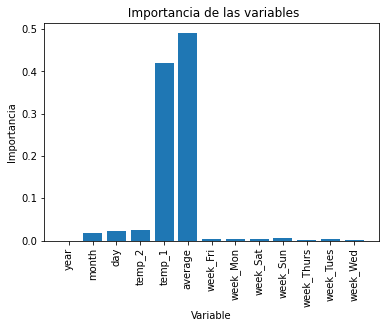

In [44]:
# lista de ubicaciones x para el gráfico
x_values = list(range(len(importances)))

# Hacer un gráfico de barras
plt.bar(x_values, importances, orientation = 'vertical')

# Etiquetas para el eje x
plt.xticks(x_values, df_list, rotation='vertical')

# Etiquetas y título de los ejes
plt.ylabel('Importancia'); plt.xlabel('Variable'); plt.title(' Importancia de las variables') 

In [40]:
# Fechas de los valores de formación
months = df[:, df_list.index('month')]
days = df[:, df_list.index('day')]
years = df[:, df_list.index('year')]

# Listar y luego convertir a objeto datetime
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe con valores reales y fechas
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# Fechas de las predicciones
months = test_features[:, df_list.index('month')]
days = test_features[:, df_list.index('day')]
years = test_features[:, df_list.index('year')]

# Columna de fechas
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convertir a objetos datetime
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe con predicciones y fechas
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions}) 



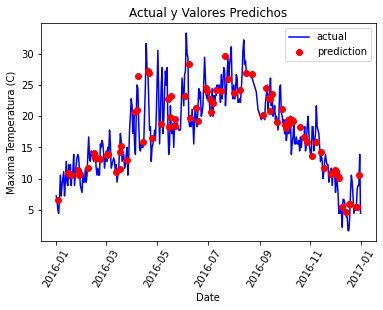

In [42]:
# Plot de los valores reales
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Representar los valores predichos
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Etiquetas del gráfico
plt.xlabel('Date'); plt.ylabel('Maxima Temperatura (C)'); plt.title('Actual y Valores Predichos');



¡Hemos completado todo un ejemplo de aprendizaje automático de principio a fin! Llegados a este punto, si queremos mejorar nuestro modelo, podríamos probar diferentes hiperparámetros (ajustes), probar un algoritmo diferente, o otro enfoque importante seria recopilar más datos. El rendimiento de cualquier modelo es directamente proporcional a la cantidad de datos válidos de los que puede aprender, y estábamos utilizando una cantidad muy limitada de información para el entrenamiento.

* Podemos transformar esto en un problema de clasificacion ??? Mejoraria o empeoraria la performance ?

<a id="docs"></a>
### Documentación
- [Random Forest Regressor con Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- [Random Forest Berkeley](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm)
